In [1]:
import pandas as pd

# Load dataset from a CSV file
data_path = '/content/drive/MyDrive/dataset/all-the-news-combined.csv'
data = pd.read_csv(data_path)
data.dropna(subset=['author', 'content'], inplace=True)  # Remove rows with missing 'author' or 'content'

<ipython-input-1-447bde78b5cb>:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


In [2]:
# Filter data to include only authors with a significant number (400 or more) of articles
author_counts = data['author'].value_counts()
frequent_authors = author_counts[author_counts >= 400].index

# List of grouped authors (not individuals) to be excluded from the analysis
authors_to_exclude = [
    "Associated Press",
    "Breitbart Jerusalem",
    "Breitbart London",
    "Breitbart News",
    "Editorial Board",
    "Fox News",
    "NPR Staff",
    "Post Editorial Board",
    "Post Staff Report",
    "Reuters",
    "The Editors"
]

# Apply filters to the dataset
data = data[data['author'].isin(frequent_authors) & ~data['author'].isin(authors_to_exclude)]

# Display the names of qualified authors
qualified_authors = data['author'].unique()
print("Qualified Authors:")
for author in qualified_authors:
    print(author)

Qualified Authors:
Camila Domonoske
Merrit Kennedy
Bill Chappell
Ian Hanchett
Katherine Rodriguez
Jerome Hudson
Charlie Spiering
AWR Hawkins
Warner Todd Huston
Jeff Poor
Trent Baker
Daniel Nussbaum
John Hayward
Pam Key
Joel B. Pollak
Charlie Nash
Alex Swoyer


In [3]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')  # Download the Punkt tokenizer models

# Tokenize the content of each article into sentences using NLTK's sent_tokenize
data['sentences'] = data['content'].apply(sent_tokenize)

# Explode the DataFrame to separate each sentence into its own row, while keeping the associated author the same
# This operation transforms each list of sentences into separate rows, duplicating the other column values as needed.
data = data.explode('sentences').reset_index(drop=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')

# Function to preprocess text by removing digits, punctuation, and stop words, and applying lemmatization
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    return ' '.join(lemmatizer.lemmatize(word) for word in words if word not in stop_words)

# Apply preprocessing to each content entry in the dataset
data['processed_content'] = data['sentences'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare for TF-IDF vectorization
all_words = set()
data['processed_content'].str.split().apply(all_words.update)
max_features = len(all_words)  # Set the maximum number of features as the total number of unique words

# Vectorize the processed text using TF-IDF method
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, min_df=3, max_df=0.9, ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(data['processed_content'])
y = data['author']

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode author names into categorical labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [7]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and train an SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Initialize and train a Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_test)

# Print classification reports for SVM and Logistic Regression
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=encoder.classes_))

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg, target_names=encoder.classes_))

SVM Classification Report:
                     precision    recall  f1-score   support

        AWR Hawkins       0.75      0.72      0.73      2604
        Alex Swoyer       0.51      0.37      0.43      1594
      Bill Chappell       0.56      0.36      0.43      1779
   Camila Domonoske       0.41      0.51      0.45      3254
       Charlie Nash       0.70      0.48      0.57      1843
   Charlie Spiering       0.48      0.42      0.45      2546
    Daniel Nussbaum       0.52      0.47      0.49      3157
       Ian Hanchett       0.62      0.27      0.38      1833
          Jeff Poor       0.49      0.24      0.32      2059
      Jerome Hudson       0.45      0.45      0.45      3256
     Joel B. Pollak       0.51      0.48      0.49      3164
       John Hayward       0.40      0.66      0.50      6052
Katherine Rodriguez       0.51      0.25      0.33      1120
     Merrit Kennedy       0.56      0.39      0.46      1846
            Pam Key       0.34      0.54      0.41      3

SVM Model Evaluation
Accuracy: 0.4732028874498062
Precision: 0.5424386828383312
Recall: 0.428232679539871
F1 Score: 0.45896037222353575


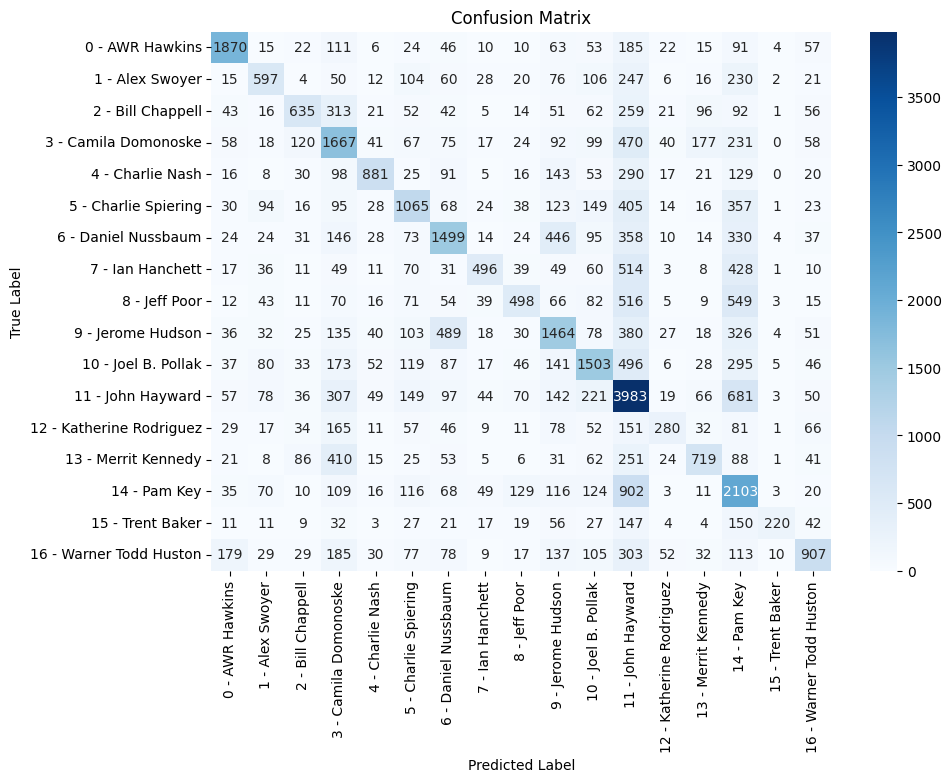

Detailed Confusion Matrix Breakdown:
Author 0 - TP: 1870, FP: 620, FN: 734, TN: 39859
Author 1 - TP: 597, FP: 579, FN: 997, TN: 40910
Author 2 - TP: 635, FP: 507, FN: 1144, TN: 40797
Author 3 - TP: 1667, FP: 2448, FN: 1587, TN: 37381
Author 4 - TP: 881, FP: 379, FN: 962, TN: 40861
Author 5 - TP: 1065, FP: 1159, FN: 1481, TN: 39378
Author 6 - TP: 1499, FP: 1406, FN: 1658, TN: 38520
Author 7 - TP: 496, FP: 310, FN: 1337, TN: 40940
Author 8 - TP: 498, FP: 513, FN: 1561, TN: 40511
Author 9 - TP: 1464, FP: 1810, FN: 1792, TN: 38017
Author 10 - TP: 1503, FP: 1428, FN: 1661, TN: 38491
Author 11 - TP: 3983, FP: 5874, FN: 2069, TN: 31157
Author 12 - TP: 280, FP: 273, FN: 840, TN: 41690
Author 13 - TP: 719, FP: 563, FN: 1127, TN: 40674
Author 14 - TP: 2103, FP: 4171, FN: 1781, TN: 35028
Author 15 - TP: 220, FP: 43, FN: 580, TN: 42240
Author 16 - TP: 907, FP: 613, FN: 1385, TN: 40178
Logistic Regression Model Evaluation
Accuracy: 0.47898242926444307
Precision: 0.5520083434247053
Recall: 0.4287763

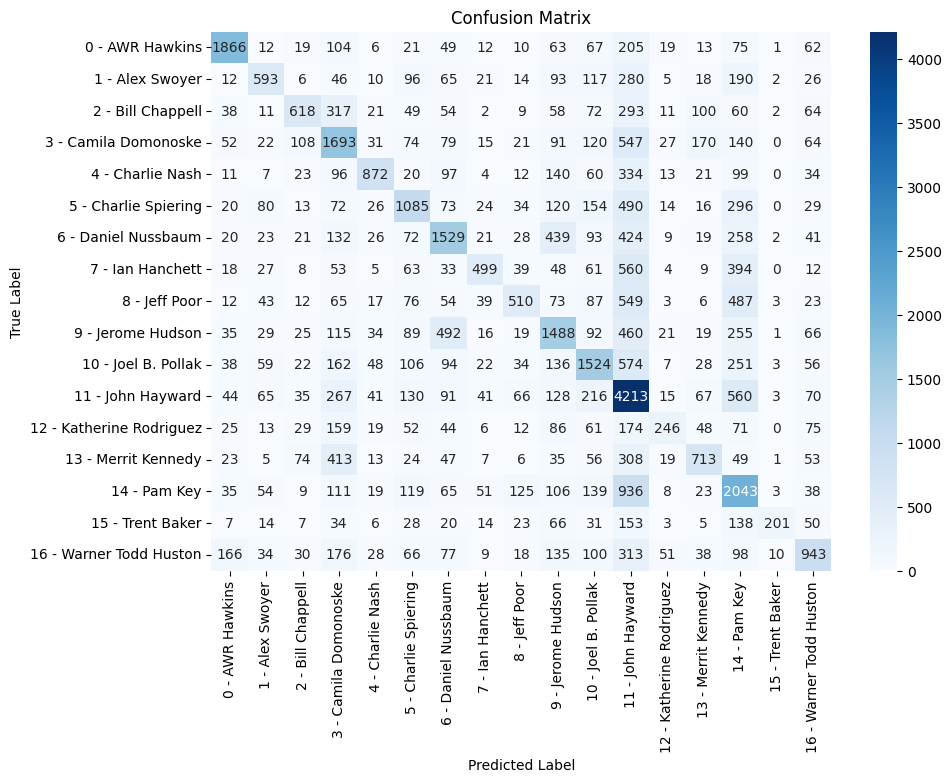

Detailed Confusion Matrix Breakdown:
Author 0 - TP: 1866, FP: 556, FN: 738, TN: 39923
Author 1 - TP: 593, FP: 498, FN: 1001, TN: 40991
Author 2 - TP: 618, FP: 441, FN: 1161, TN: 40863
Author 3 - TP: 1693, FP: 2322, FN: 1561, TN: 37507
Author 4 - TP: 872, FP: 350, FN: 971, TN: 40890
Author 5 - TP: 1085, FP: 1085, FN: 1461, TN: 39452
Author 6 - TP: 1529, FP: 1434, FN: 1628, TN: 38492
Author 7 - TP: 499, FP: 304, FN: 1334, TN: 40946
Author 8 - TP: 510, FP: 470, FN: 1549, TN: 40554
Author 9 - TP: 1488, FP: 1817, FN: 1768, TN: 38010
Author 10 - TP: 1524, FP: 1526, FN: 1640, TN: 38393
Author 11 - TP: 4213, FP: 6600, FN: 1839, TN: 30431
Author 12 - TP: 246, FP: 229, FN: 874, TN: 41734
Author 13 - TP: 713, FP: 600, FN: 1133, TN: 40637
Author 14 - TP: 2043, FP: 3421, FN: 1841, TN: 35778
Author 15 - TP: 201, FP: 31, FN: 599, TN: 42252
Author 16 - TP: 943, FP: 763, FN: 1349, TN: 40028


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    labels = [f'{i} - {cls}' for i, cls in enumerate(classes)]
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    return cm

# Function to evaluate the model and print performance metrics
def evaluate_model(name, y_true, y_pred, classes):
    print(f"{name} Model Evaluation")
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    precision = precision_score(y_true, y_pred, average='macro')
    print("Precision:", precision)
    recall = recall_score(y_true, y_pred, average='macro')
    print("Recall:", recall)
    f1 = f1_score(y_true, y_pred, average='macro')
    print("F1 Score:", f1)
    cm = plot_confusion_matrix(y_true, y_pred, classes)
    print("Detailed Confusion Matrix Breakdown:")
    for i in range(len(classes)):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        print(f"Author {i} - TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

# Evaluate and print the performance of the SVM and Logistic Regression models
evaluate_model("SVM", y_test, y_pred_svm, encoder.classes_)
evaluate_model("Logistic Regression", y_test, y_pred_log_reg, encoder.classes_)

In [12]:
pip install joblib

In [13]:
from joblib import dump

# Save the SVM model
dump(svm_model, '/content/svm_model.joblib')

# Save the Logistic Regression model
dump(log_reg_model, '/content/log_reg_model.joblib')

# Save the TF-IDF Vectorizer
dump(tfidf_vectorizer, '/content/tfidf_vectorizer.joblib')

# Save the LabelEncoder
dump(encoder, '/content/label_encoder.joblib')

['/content/label_encoder.joblib']

In [14]:
import zipfile

# Create a zip file containing all necessary files
with zipfile.ZipFile('/content/model_files.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('/content/svm_model.joblib', arcname='svm_model.joblib')
    zipf.write('/content/log_reg_model.joblib', arcname='log_reg_model.joblib')
    zipf.write('/content/tfidf_vectorizer.joblib', arcname='tfidf_vectorizer.joblib')
    zipf.write('/content/label_encoder.joblib', arcname='label_encoder.joblib')